In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
#plt.rc('text', usetex=False)
import qutip
from scipy.linalg import sqrtm

from povm_clf import *

from sympy.physics.quantum.circuitplot import CircuitPlot,CreateOneQubitGate
from sympy.physics.quantum.gate import *

---
## 1. Functions in povm_clf

### 1-1. Two-Qubit State Preparation

In [2]:
two_bloch_vecs = [[0,0,1],[1,0,0]]

- Circuit Diagram

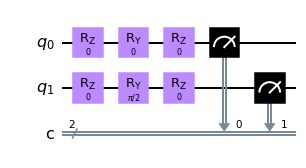

In [10]:
dev_qiskit = qml.device("qiskit.aer", wires=2)
@qml.qnode(dev_qiskit)
def circ_test():
    for i, vec in enumerate(two_bloch_vecs):
        State_Preparation(vec).state_prepared_on_circuit(wires=i)
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1))
circ_test()
dev_qiskit._circuit.draw(output="mpl")

### 1-2. (Controlled) Universal Two-Qubit Gates

#### Universal Two-Qubit Gates, SU(4)

In [4]:
def SU4(params, wires):
    # two-qubit SU(4) gates designed by V. V. Shende et al., PRA 69 062321 (2004)
    qml.Rot(params[0], params[1], params[2], wires=wires[0])
    qml.Rot(params[3], params[4], params[5], wires=wires[1])

    qml.CNOT(wires=[wires[1], wires[0]])

    qml.RZ(params[6], wires=wires[0])
    qml.RY(params[7], wires=wires[1])

    qml.CNOT(wires=[wires[0], wires[1]])

    qml.RY(params[8], wires=wires[1])
    qml.CNOT(wires=[wires[1], wires[0]])

    qml.Rot(params[9], params[10], params[11], wires=wires[0])
    qml.Rot(params[12], params[13], params[14], wires=wires[1])

- Circuit Diagram

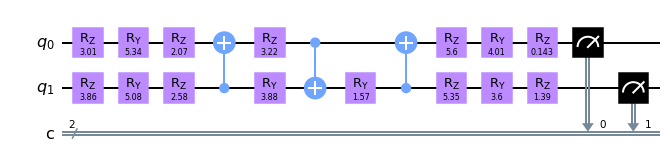

In [5]:
dev_qiskit = qml.device("qiskit.aer", wires=2)
@qml.qnode(dev_qiskit)
def circ_test():
    params = 2* np.pi * np.random.random([15])
    SU4(params, wires=[0,1])
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1))
circ_test()
dev_qiskit._circuit.draw(output="mpl")

#### Uniformly CCRY gate

In [6]:
def CCRY(phi, wires):
    # 
    phi = phi/2
    qml.CRY(phi, wires=[wires[1], wires[2]])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.CRY((-1)*phi, wires=[wires[1], wires[2]])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.CRY(phi, wires=[wires[0], wires[2]])

def UCCRY(params, wires):
    qml.PauliX(wires=wires[0])
    qml.PauliX(wires=wires[1])
    CCRY(phi=params[0], wires=[wires[0], wires[1], wires[2]])
    qml.PauliX(wires=wires[1])
    qml.PauliX(wires=wires[0])
    
    qml.PauliX(wires=wires[0])
    CCRY(phi=params[1], wires=[wires[0], wires[1], wires[2]])
    qml.PauliX(wires=wires[0])

    qml.PauliX(wires=wires[1])
    CCRY(phi=params[2], wires=[wires[0], wires[1], wires[2]])
    qml.PauliX(wires=wires[1])

    CCRY(phi=params[3], wires=[wires[0], wires[1], wires[2]])

- Circuit Diagram

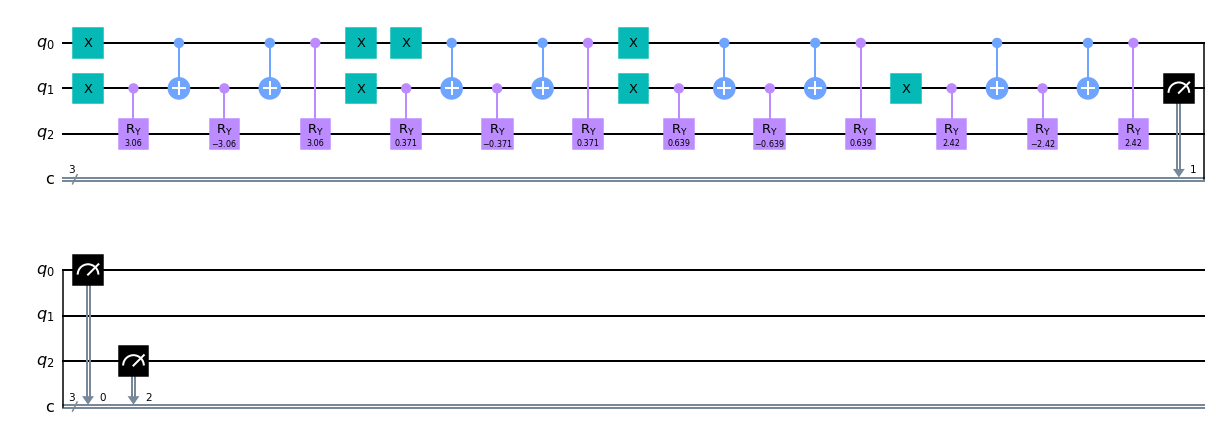

In [7]:
dev_qiskit = qml.device("qiskit.aer", wires=3)
@qml.qnode(dev_qiskit)
def circ_test():
    params = 2* np.pi * np.random.random([4])
    UCCRY(params, wires=[0,1,2])
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1) @ qml.PauliZ(2))
circ_test()
dev_qiskit._circuit.draw(output="mpl")

#### Two-element Two-qubit POVM Module

In [8]:
def two_element_povm(params, wires):
    SU4(params[:15], wires=[wires[0],wires[1]])
    UCCRY(params[15:19], wires=[wires[0],wires[1],wires[2]])

- Circuit Diagram

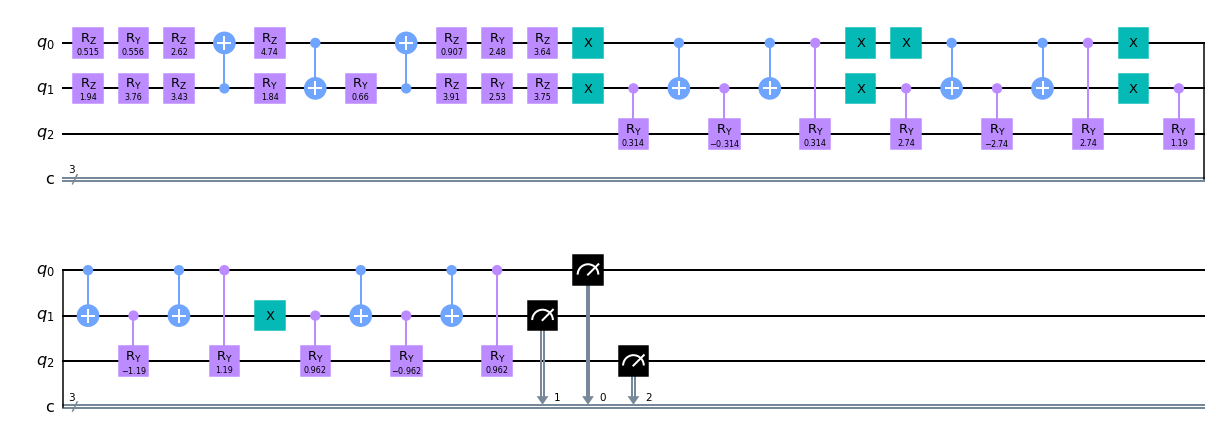

In [9]:
dev_qiskit = qml.device("qiskit.aer", wires=3)
@qml.qnode(dev_qiskit)
def circ_test():
    params = 2* np.pi * np.random.random([19])
    two_element_povm(params, wires=[0,1,2])
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1)@ qml.PauliZ(2))
circ_test()
dev_qiskit._circuit.draw(output="mpl")

#### Controlled two-element POVM

In [159]:
def C2ePOVM(params, wires):
    ctrl_2ePOVM = qml.ctrl(two_element_povm, control=wires[0])
    ctrl_2ePOVM(params, wires=[wires[1],wires[2],wires[3]])

- Circuit Diagram

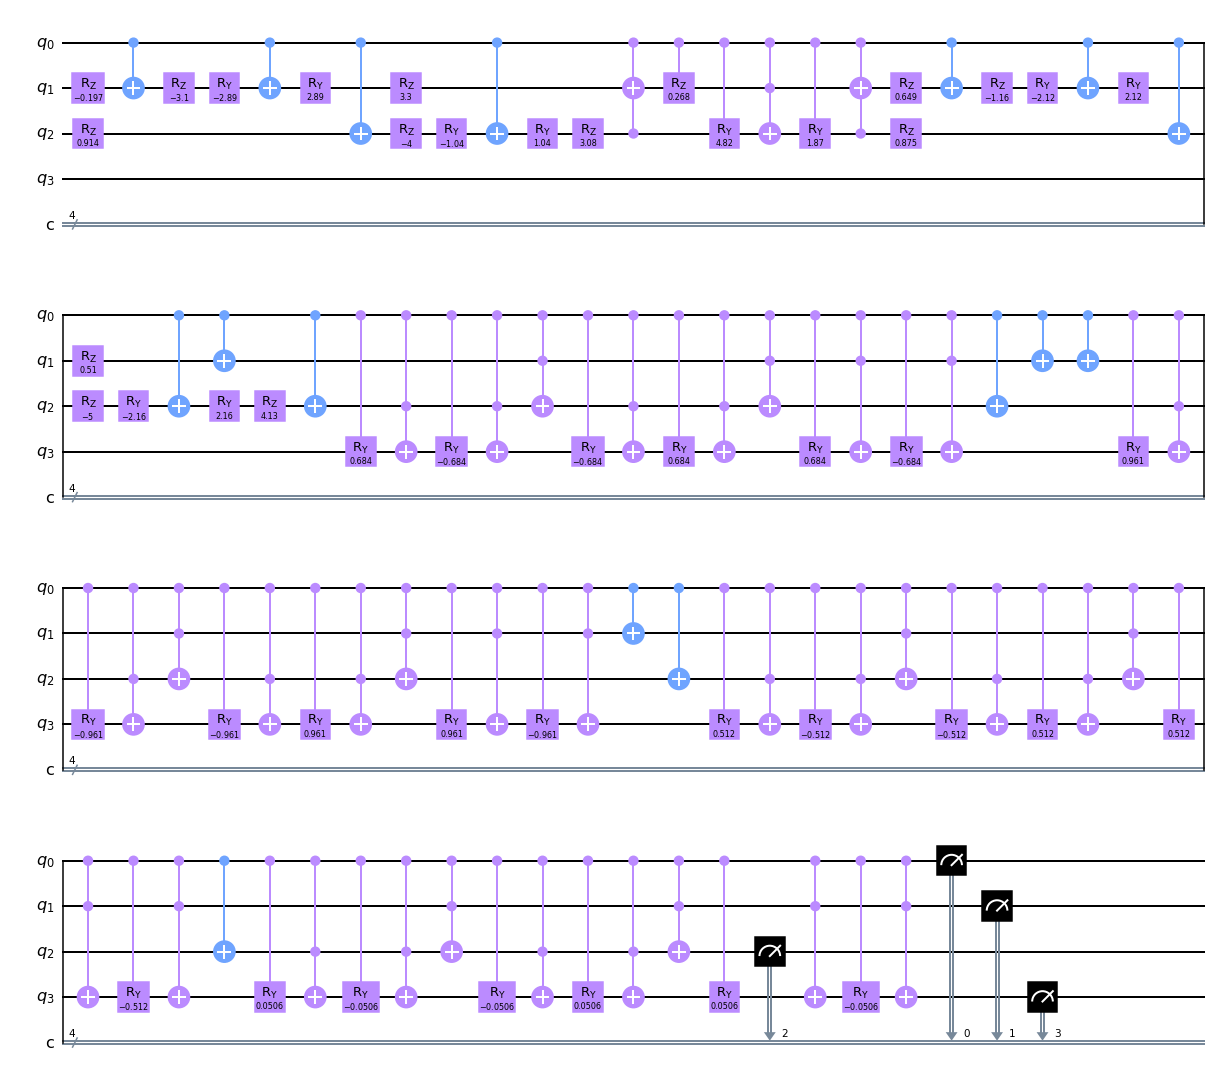

In [162]:
dev_qiskit = qml.device("qiskit.aer", wires=4)
@qml.qnode(dev_qiskit)
def circ_test():
    params = 2* np.pi * np.random.random([19])
    C2ePOVM(params, wires=[0,1,2,3])
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1)@ qml.PauliZ(2))
circ_test()
dev_qiskit._circuit.draw(output="mpl")

### 1-3. Four-element POVMs for two qubits

In [2]:
def four_element_povm(params, wires):
    two_element_povm(params[:19], wires=[wires[0],wires[1],wires[2]])
    qml.PauliX(wires=wires[2])
    C2ePOVM(params[19:38], wires=[wires[2],wires[0],wires[1],wires[3]])
    qml.PauliX(wires=wires[2])
    C2ePOVM(params[38:], wires=[wires[2],wires[0],wires[1],wires[3]])

- Circuit Diagram

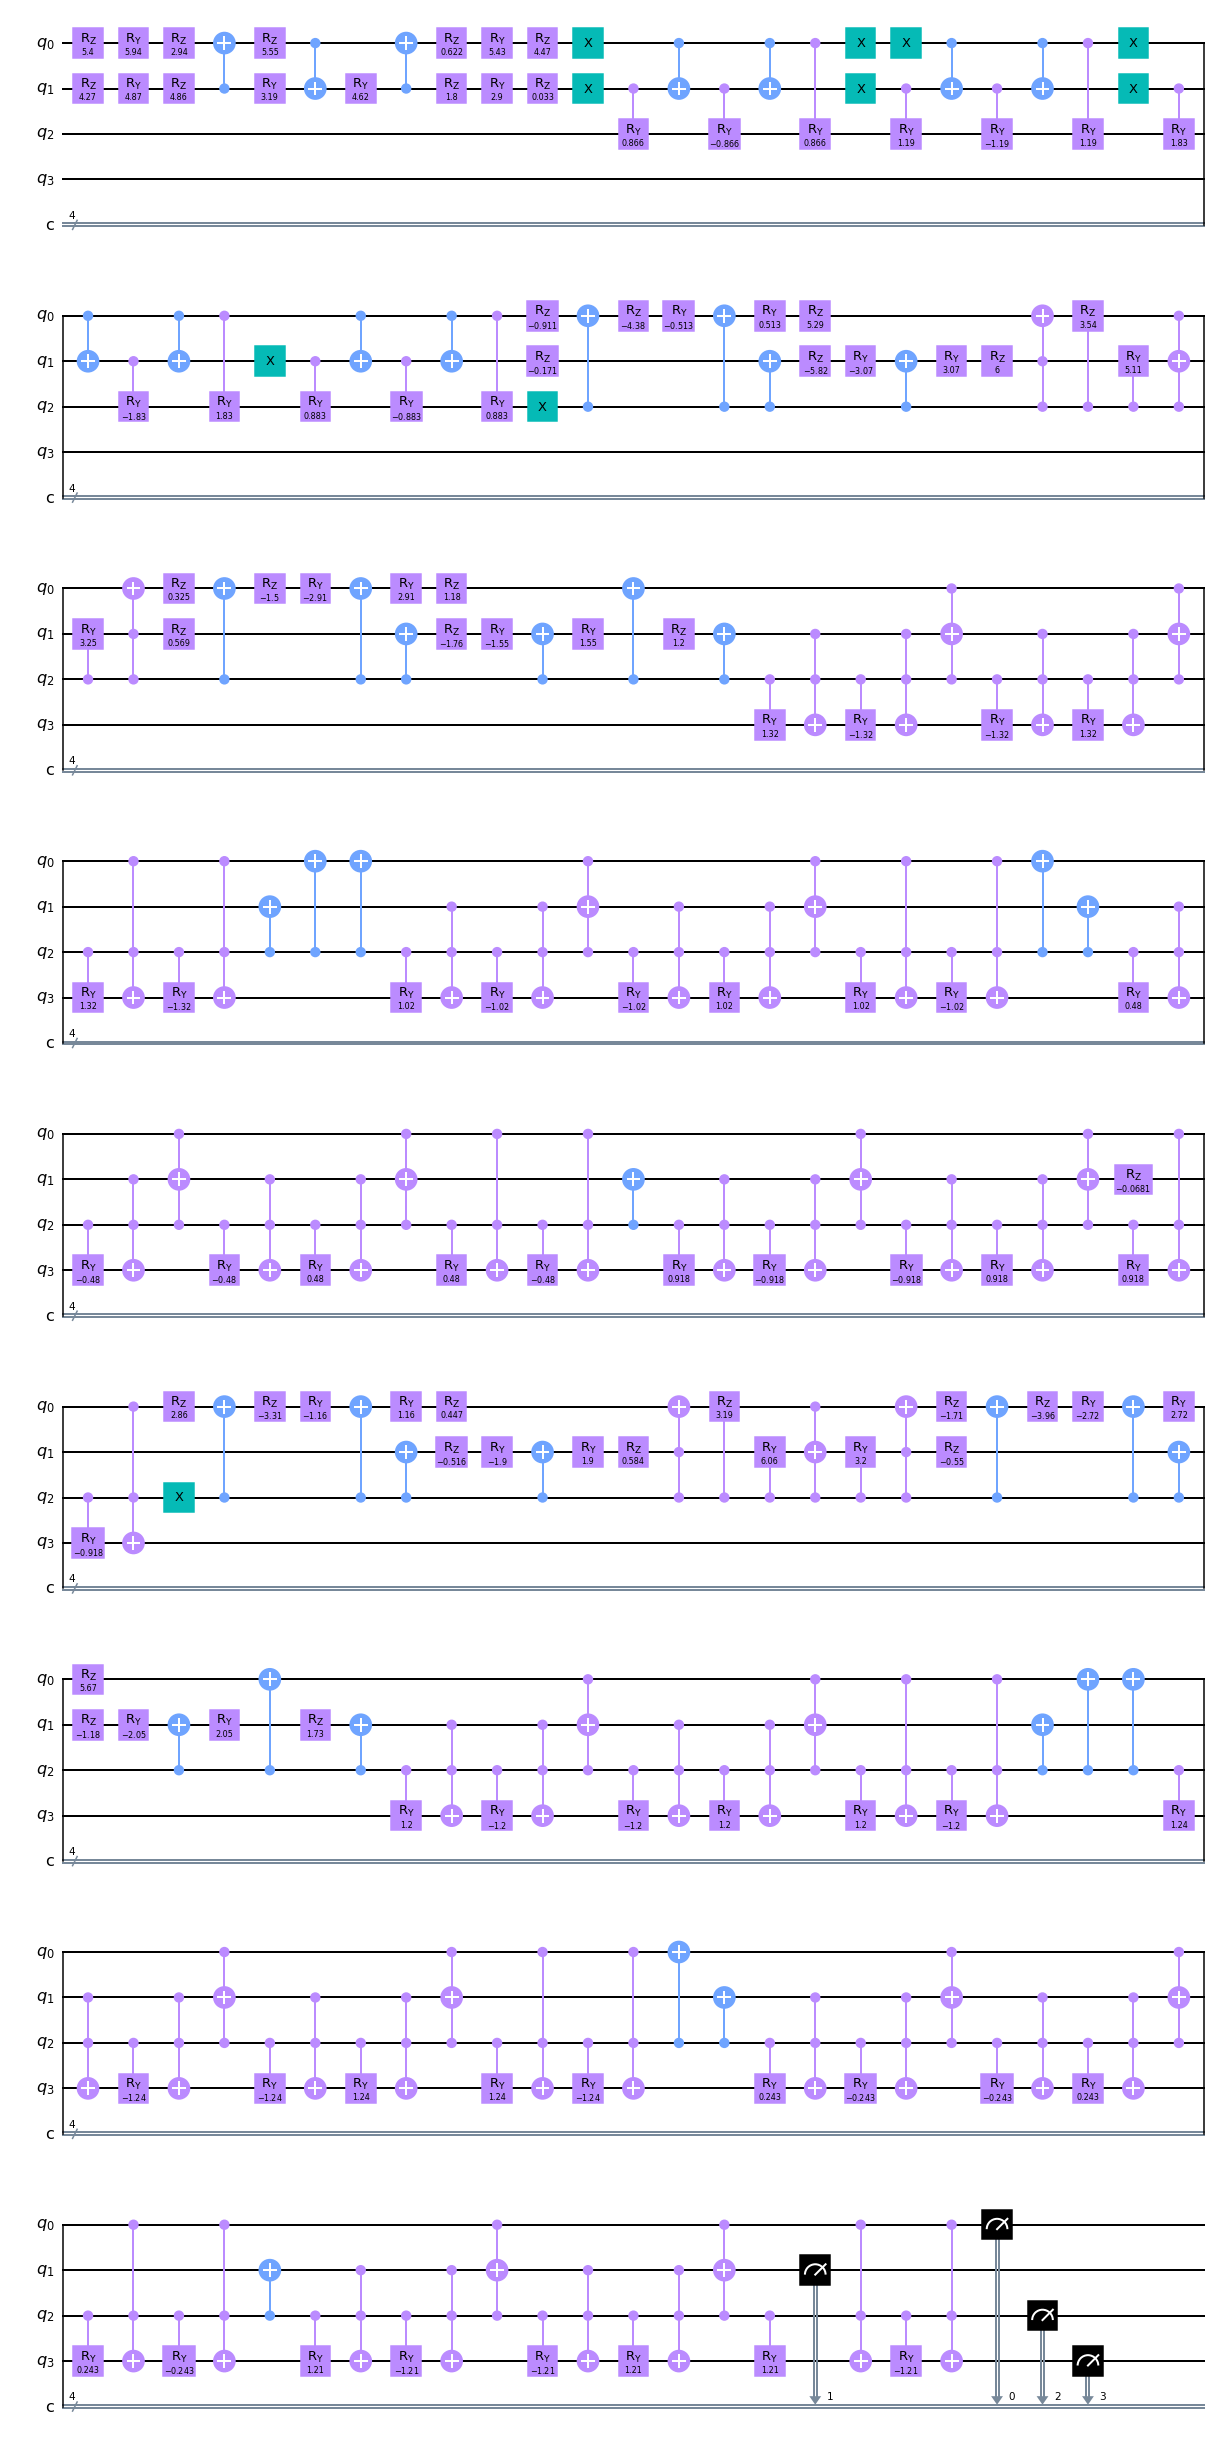

In [175]:
dev_qiskit = qml.device("qiskit.aer", wires=4)
@qml.qnode(dev_qiskit)
def circ_test():
    params = 2* np.pi * np.random.random([57])
    four_element_povm(params, wires=[0,1,2,3])
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1)@ qml.PauliZ(2))
circ_test()
dev_qiskit._circuit.draw(output="mpl")

---
## 2. Pure-state Classifier

###  Four-element POVMs

#### i)
$q_0=q_1=q_2=q_3=1/4$<br>
$\{|00\rangle, |+0\rangle, |0+\rangle, |++\rangle\}$

In [2]:
n = 4
devs = [qml.device('default.qubit', wires=n)] * n
wires = [0, 1, 2, 3]
a_priori_probs = [1/n] * n

two_bloch_vecs = [[[0,0,1], [0,0,1]], [[1,0,0], [0,0,1]], [[0,0,1], [1,0,0]], [[1,0,0], [1,0,0]]]
#two_bloch_vecs = [[[0,0,1], [0,0,1]], [[0,0,1], [0,0,-1]], [[0,0,-1], [0,0,1]], [[0,0,-1], [0,0,-1]]]

In [14]:
classifier = TQ_POVM_Clf(4, wires, devs, a_priori_probs, two_bloch_vecs)

In [15]:
steps = 500
cost_list = classifier.run_opt(steps)

Cost after step    20:  0.5234393
Cost after step    40:  0.4458924
Cost after step    60:  0.4270645
Cost after step    80:  0.4110552
Cost after step   100:  0.3893023
Cost after step   120:  0.3600826
Cost after step   140:  0.3283466
Cost after step   160:  0.3033159
Cost after step   180:  0.2885258
Cost after step   200:  0.2809065
Cost after step   220:  0.2770377
Cost after step   240:  0.2749983
Cost after step   260:  0.2738592
Cost after step   280:  0.2731796
Cost after step   300:  0.2727469
Cost after step   320:  0.2724553
Cost after step   340:  0.2722494
Cost after step   360:  0.2720988
Cost after step   380:  0.2719854
Cost after step   400:  0.2718983
Cost after step   420:  0.2718302
Cost after step   440:  0.2717762
Cost after step   460:  0.2717328
Cost after step   480:  0.2716974
Cost after step   500:  0.2716684


In [16]:
opt_params = classifier.povm_params
classifier.qnodes(opt_params)

array([[0.72865085, 0.12484703, 0.12513643, 0.02136569],
       [0.12577199, 0.72778587, 0.02153804, 0.1249041 ],
       [0.12504386, 0.02135945, 0.72850079, 0.12509589],
       [0.02165793, 0.12479718, 0.12515604, 0.72838884]])

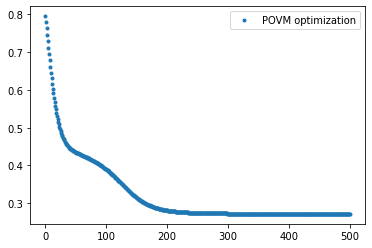

In [17]:
plt.plot(list(range(steps+1)), cost_list, '.', label='POVM optimization')
plt.legend()
plt.show()

Construct code that finds optimal POVMS

In [18]:
rho = classifier.density_matrices
K = classifier.kraus_op()
E = classifier.povm()
med_povm = 1 - (1/n)*np.sum([np.real(np.trace(np.dot(rho[i],E[i]))) for i in range(n)], axis=0)
pgm, med_pgm = classifier.pgm()
print("Minimum-Error Discrimination")
print("performed optimal POVM:", med_povm)
print("performed PGM:", med_pgm)

classifier.res_table()

AttributeError: 'TQ_POVM_Clf' object has no attribute 'kraus_op'

Check!!  <br>
In pennylane, <br>
get_unitary_matrix(circuit[, wire_order])

#### Get Unitary Matrix 

#### Ex1


In [25]:
def circuit(theta):
    
    qml.PauliZ(wires=0)
    qml.RY(theta, wires=1)
    
    #qml.PauliY(wires=1)
    
get_matrix = qml.transforms.get_unitary_matrix(circuit, wire_order=[0,1])
get_matrix(0)

array([[ 1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0.,  0., -1.]])

In [13]:
classifier.cost_fn(classifier.povm_params)


0.0001526884229033909

#### Ex2 SU(4)

In [33]:
def circuit(params):
    TwoQubitPOVM(n=4).SU4(params, wires=[0,1])

get_matrix = qml.transforms.get_unitary_matrix(circuit, wire_order=[0,1])
get_matrix(opt_params[:15])

tensor([[ 4.41625374e-01+1.88817793e-01j,
         -8.53119043e-01+2.03722283e-01j,
          6.68918931e-08+1.01899164e-07j,
          1.92641652e-08+3.93882274e-11j],
        [ 2.79472379e-09-1.13822118e-07j,
         -2.26473019e-08-6.92192725e-09j,
         -1.14155361e-01+2.19666955e-01j,
         -6.45216298e-01+7.22779988e-01j],
        [ 1.09175930e-08-3.36233266e-08j,
          1.01385104e-07+5.98281605e-08j,
         -3.05391332e-01+9.19484158e-01j,
          1.33625094e-01-2.08397101e-01j],
        [-6.01564577e-01+6.38306298e-01j,
         -5.62268592e-02+4.76994413e-01j,
          7.95861714e-09+2.44057358e-08j,
         -1.12882604e-07-1.27756031e-09j]], requires_grad=True)

In [36]:
get_matrix = qml.transforms.get_unitary_matrix(TwoQubitPOVM(n=4).SU4, wire_order=[0,1])
get_matrix(opt_params[:15], wires=[0,1])

tensor([[ 4.41625374e-01+1.88817793e-01j,
         -8.53119043e-01+2.03722283e-01j,
          6.68918931e-08+1.01899164e-07j,
          1.92641652e-08+3.93882274e-11j],
        [ 2.79472379e-09-1.13822118e-07j,
         -2.26473019e-08-6.92192725e-09j,
         -1.14155361e-01+2.19666955e-01j,
         -6.45216298e-01+7.22779988e-01j],
        [ 1.09175930e-08-3.36233266e-08j,
          1.01385104e-07+5.98281605e-08j,
         -3.05391332e-01+9.19484158e-01j,
          1.33625094e-01-2.08397101e-01j],
        [-6.01564577e-01+6.38306298e-01j,
         -5.62268592e-02+4.76994413e-01j,
          7.95861714e-09+2.44057358e-08j,
         -1.12882604e-07-1.27756031e-09j]], requires_grad=True)

#### Test

In [13]:
opt_povms = classifier.povm()

In [24]:
U_list = []
cos_list = []
sin_list = []
for i in range(3):
    U_list.append(classifier.SU4_matrices(opt_params[19*i:19*i+15]))
    cos_, sin_ = classifier.diag_matrices_from_RY(opt_params[19*i+15:19*(i+1)])
    cos_list.append(cos_)
    sin_list.append(sin_)

In [38]:
mid = np.dot(np.dot(cos_list[1], U_list[1]), np.dot(cos_list[0], U_list[0]))
np.real(np.dot(mid.conjugate().transpose(), mid))

tensor([[ 9.99245749e-01,  2.47742890e-04,  3.24993033e-03,
         -1.75089896e-02],
        [ 2.47742890e-04,  9.99755579e-01,  2.84675853e-04,
          8.96539223e-03],
        [ 3.24993033e-03,  2.84675853e-04,  4.00814915e-02,
          1.32937246e-01],
        [-1.75089896e-02,  8.96539223e-03,  1.32937246e-01,
          5.09489933e-01]], requires_grad=True)

In [36]:
U_list[1]

tensor([[ 0.0283803 -2.40340808e-02j,  0.97746741+2.05719693e-01j,
          0.00785263+1.48544621e-02j, -0.01852649-1.51079748e-02j],
        [ 0.46419567-1.22607842e-01j,  0.00439906-1.14091319e-03j,
         -0.00490681+1.41374920e-03j,  0.50206496+7.19286966e-01j],
        [-0.09635599+8.71067149e-01j,  0.03653136-2.47365824e-02j,
         -0.0084116 +7.05351232e-04j,  0.46561126-1.14656046e-01j],
        [ 0.00116925-7.92427270e-03j,  0.01360808-9.19822245e-03j,
         -0.95752018-2.87707242e-01j, -0.0045771 -4.97480773e-03j]], requires_grad=True)

In [22]:
opt_params.shape

(57,)

In [9]:
psi = np.array([[1,0,0,0], [0,1,0,0], [0,0,1,0], [0,0,0,1]])

In [11]:
sum([a_priori_probs[i] * np.dot(psi[i],np.dot(opt_povms[i], psi[i])) for i in range(4)])

0.24987254262514022

In [12]:
opt_povms[1]

tensor([[ 7.54250566e-04, -2.47742865e-04, -3.24993033e-03,
          1.75089896e-02],
        [-2.47742865e-04,  2.44421086e-04, -2.84675853e-04,
         -8.96539223e-03],
        [-3.24993033e-03, -2.84675853e-04,  9.59918509e-01,
         -1.32937246e-01],
        [ 1.75089896e-02, -8.96539223e-03, -1.32937246e-01,
          4.90510067e-01]], requires_grad=True)

In [62]:
np.dot(psi[1],np.dot(opt_povms[1], psi[1]))

(0.0002444210864024047+4.606054190352263e-21j)

In [63]:
np.dot(psi[2],np.dot(opt_povms[2], psi[2]))

(4.670046969349471e-15+1.7298984127256533e-32j)

In [64]:
np.dot(psi[3],np.dot(opt_povms[3], psi[3]))

(1.9904663463505073e-17-9.643644807121684e-35j)

In [35]:
opt_povms[2]

tensor([[ 1.43511538e-11+5.81185226e-29j,
         -2.08883077e-11+1.60739682e-11j,
          8.45528405e-16+2.92197502e-16j,
          1.52648182e-15+1.95970718e-15j],
        [-2.08883077e-11-1.60739682e-11j,
          4.88593872e-11-1.45913337e-28j,
         -3.55706356e-15+1.38001064e-15j,
         -1.02415715e-14+2.02389608e-15j],
        [ 8.45528405e-16-2.92197502e-16j,
         -3.55706356e-15-1.38001064e-15j,
          4.67004697e-15+1.72989841e-32j,
          8.39628318e-15+2.13975311e-15j],
        [ 1.52648182e-15-1.95970718e-15j,
         -1.02415715e-14-2.02389608e-15j,
          8.39628318e-15-2.13975311e-15j,
          3.63741363e-14-3.30906625e-32j]], requires_grad=True)

#### ii)
$q_0=q_1=q_2=q_3=1/4$<br>
$\{|00\rangle+|11\rangle, |00\rangle-|11\rangle, |01\rangle+|10\rangle, |01\rangle-|10\rangle \}$

In [19]:
n = 4
devs = [qml.device('default.qubit', wires=n)] * n
wires = [0, 1, 2, 3]
a_priori_probs = [1/n] * n


In [20]:
dev_qiskit = qml.device("qiskit.aer", wires=2)
@qml.qnode(dev_qiskit)
def circ_test():
    for i, vec in enumerate(two_bloch_vecs):
        State_Preparation(vec).state_prepared_on_circuit(wires=i)
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1))
circ_test()
dev_qiskit._circuit.draw(output="mpl")

ValueError: shapes (2,3) and (2,3) not aligned: 3 (dim 1) != 2 (dim 0)

In [ ]:
classifier = TQ_POVM_Clf(4, wires, devs, a_priori_probs, two_bloch_vecs)

In [ ]:
steps = 500
cost_list = classifier.run_opt(steps)

Cost after step    20:  0.5234393
Cost after step    40:  0.4458924
Cost after step    60:  0.4270645
Cost after step    80:  0.4110552
Cost after step   100:  0.3893023
Cost after step   120:  0.3600826
Cost after step   140:  0.3283466
Cost after step   160:  0.3033159
Cost after step   180:  0.2885258
Cost after step   200:  0.2809065
Cost after step   220:  0.2770377
Cost after step   240:  0.2749983
Cost after step   260:  0.2738592
Cost after step   280:  0.2731796
Cost after step   300:  0.2727469
Cost after step   320:  0.2724553
Cost after step   340:  0.2722494
Cost after step   360:  0.2720988
Cost after step   380:  0.2719854
Cost after step   400:  0.2718983
Cost after step   420:  0.2718302
Cost after step   440:  0.2717762
Cost after step   460:  0.2717328
Cost after step   480:  0.2716974
Cost after step   500:  0.2716684
